# CAR INSURANCE CLAIMS FRAUD DETECTIONS
__By Hussain Alhadab__

In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss, accuracy_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score, precision_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# !conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

# !conda install -y -c conda-forge xgboost
import xgboost

pd.set_option('display.max_columns', 35)

Populating the interactive namespace from numpy and matplotlib


# EDA

In [2]:
dataset = pd.read_excel('Dataset.xlsx')

In [3]:
dataset.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1.0,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,55526.069421
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4.0,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,59294.455571
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3.0,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,71756.941320
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2.0,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7584.153493
4,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36.0,Third Party,Sport - Collision,Sport,more than 69000,0,7,14,400,1.0,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,98545.374339


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 11565 non-null  object 
 1   WeekOfMonth           11565 non-null  int64  
 2   DayOfWeek             11565 non-null  object 
 3   Make                  11565 non-null  object 
 4   AccidentArea          11565 non-null  object 
 5   DayOfWeekClaimed      11565 non-null  object 
 6   MonthClaimed          11565 non-null  object 
 7   WeekOfMonthClaimed    11565 non-null  int64  
 8   Sex                   11565 non-null  object 
 9   MaritalStatus         11565 non-null  object 
 10  Age                   11560 non-null  float64
 11  Fault                 11565 non-null  object 
 12  PolicyType            11565 non-null  object 
 13  VehicleCategory       11565 non-null  object 
 14  VehiclePrice          11565 non-null  object 
 15  FraudFound_P       

In [5]:
dataset.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'ClaimSize'],
      dtype='object')

In [6]:
dataset.nunique()

Month                      12
WeekOfMonth                 5
DayOfWeek                   7
Make                       19
AccidentArea                2
DayOfWeekClaimed            8
MonthClaimed               13
WeekOfMonthClaimed          5
Sex                         2
MaritalStatus               4
Age                        66
Fault                       2
PolicyType                  9
VehicleCategory             3
VehiclePrice                6
FraudFound_P                2
PolicyNumber            11565
RepNumber                  16
Deductible                  4
DriverRating                4
Days_Policy_Accident        5
Days_Policy_Claim           4
PastNumberOfClaims          4
AgeOfVehicle                8
AgeOfPolicyHolder           9
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
NumberOfSuppliments         4
AddressChange_Claim         5
NumberOfCars                5
Year                        3
BasePolicy                  3
ClaimSize 

In [7]:
print('Fraud class is %{:.2} of dataset ({} data points)'.format(
    np.mean(dataset.FraudFound_P) * 100,
    len(np.where(dataset.FraudFound_P == 1)[0])))

Fraud class is %5.9 of dataset (685 data points)


In [8]:
Counter(dataset.FraudFound_P)

Counter({0: 10880, 1: 685})

<AxesSubplot:>

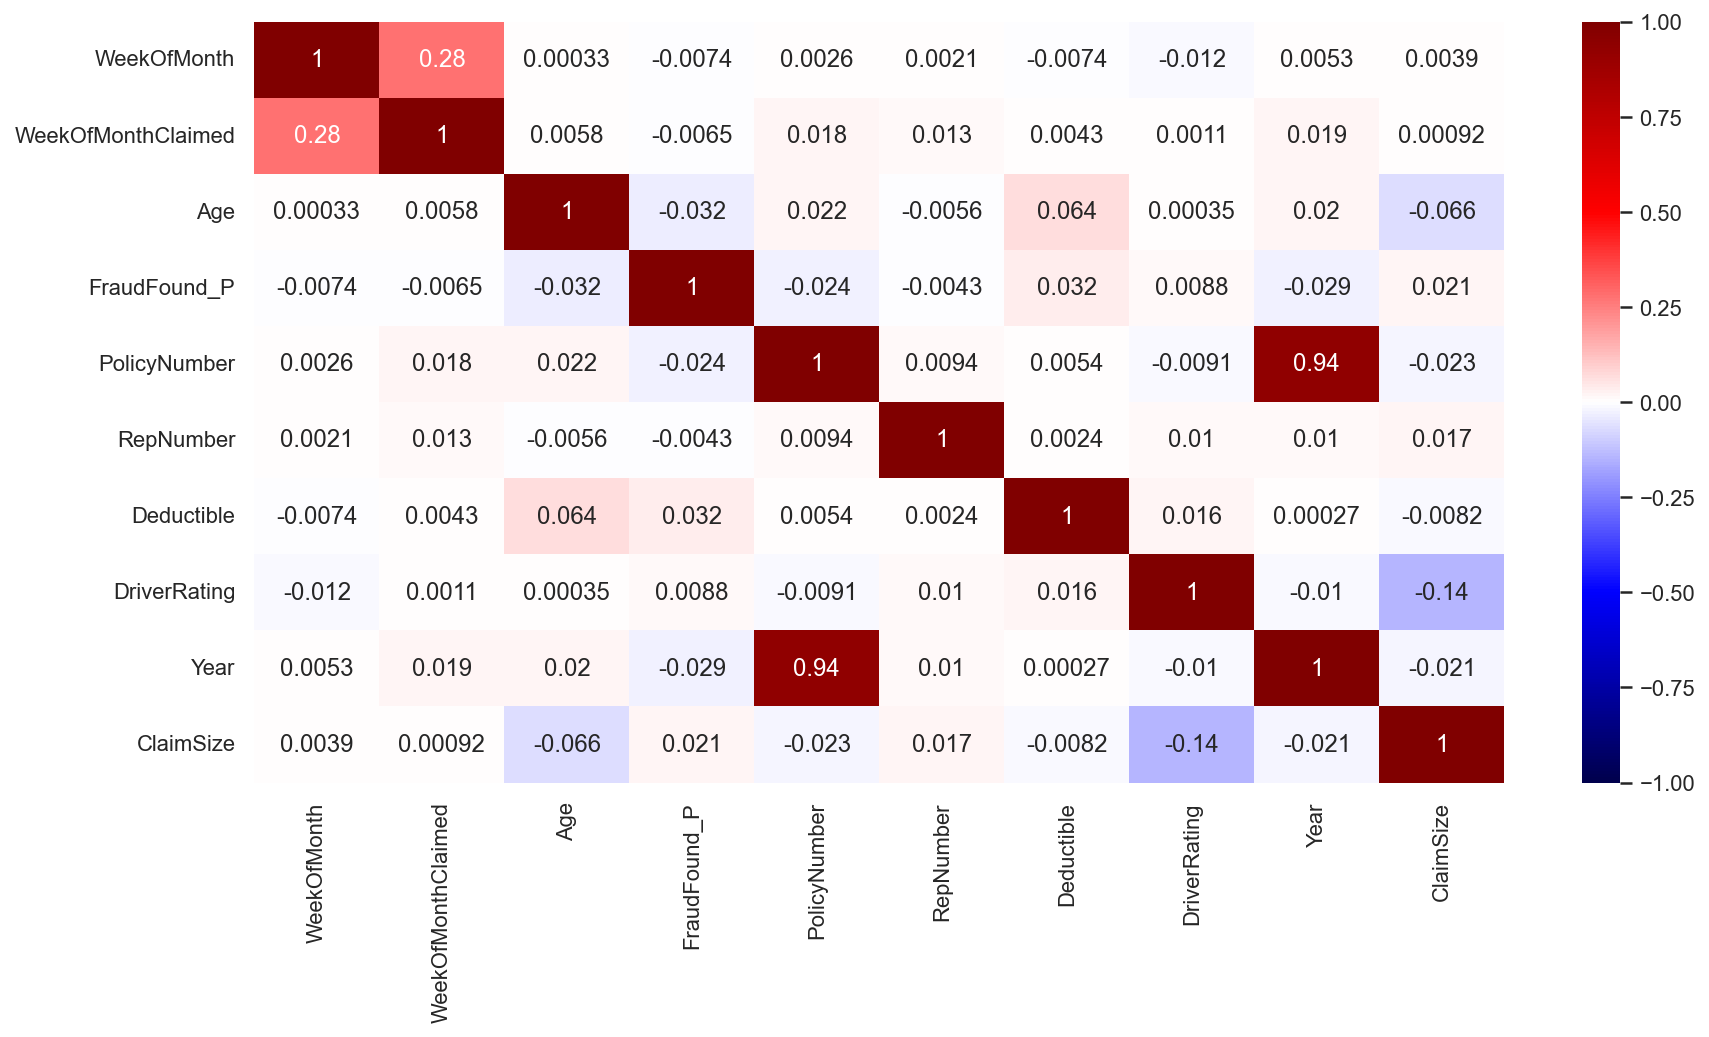

In [9]:
plt.figure(figsize=(14, 7))
sns.heatmap(dataset.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

# Display Scores & Confusion Matrix function

- The __Matthews correlation coefficient (MCC)__ is used as a measure of the quality of classifications. It regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
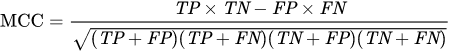


- Balanced accuracy: $ (Sensitivity + Specificity) / 2 $


- Cohen's kappa
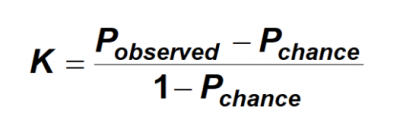

In [10]:
def printScores(model, X_test, y_test, on='Test', threshold='best', probability=True, model_name=None, plots=True):
    if model_name is None:
        model_name = type(model).__name__

    if threshold == 'best' and probability:
        threshold = f1_optimization(model, X_test, y_test, model_name=model_name, plots=plots)

    if probability:
        y_pred = model.predict_proba(X_test)[:, 1] >= threshold
        f1 = f1_score(y_test, y_pred)
        MCC = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        logLoss = log_loss(y_test, model.predict_proba(X_test))
        kappa = cohen_kappa_score(y_test, y_pred)
#         bac = balanced_accuracy_score(y_test, y_pred) # always get bac == AUC

        print()
        print('F1: %.3f, AUC: %.3f, Log-Loss: %.3f, kappa: %.3f, MCC: %.3f' %
              (f1, auc, logLoss, kappa, MCC))
        print()
    else:
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        MCC = matthews_corrcoef(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        bac = balanced_accuracy_score(y_test, y_pred)
        print()

    
    if plots:
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(dpi=150)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap=plt.cm.Blues,
                    square=True,
                    xticklabels=['Not Fraud', 'Fraud'],
                    yticklabels=['Not Fraud', 'Fraud'])
        plt.tick_params(axis='y', rotation=0)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        

    if probability:
        return f1, auc, logLoss, MCC
    else:
        return f1, np.NaN, np.NaN, MCC

In [11]:
def f1_optimization(model, X_test, y_test, model_name=None, plots=True):
    if model_name is None:
        model_name = type(model).__name__
        
    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val, model_val_labels))    
        prec_scores.append(precision_score(y_val, model_val_labels))
        rec_scores.append(recall_score(y_val, model_val_labels))
        acc_scores.append(accuracy_score(y_val, model_val_labels))
        
    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    if plots:
        plt.figure(dpi=150)
        plt.figure(figsize=(5, 4))
        plt.plot(thresh_ps, f1_scores)
        plt.plot(thresh_ps, prec_scores)
        plt.plot(thresh_ps, rec_scores)
        plt.plot(thresh_ps, acc_scores)

        plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
        plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
        plt.xlabel('P threshold')
        plt.ylabel('Metric score')    

        print(f'{model_name} Model best F1 score %.3f at prob decision threshold >= %.3f' 
              % (best_f1_score, best_thresh_p))
        
    return best_thresh_p

# Logistic Regression

## Dimensionality Reduction

'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'

LogisticRegression Model best F1 score 0.253 at prob decision threshold >= 0.135

F1: 0.253, AUC: 0.649, Log-Loss: 0.195, kappa: 0.186, MCC: 0.206

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2174
           1       0.18      0.42      0.25       137

    accuracy                           0.85      2311
   macro avg       0.57      0.65      0.59      2311
weighted avg       0.91      0.85      0.88      2311



<Figure size 900x600 with 0 Axes>

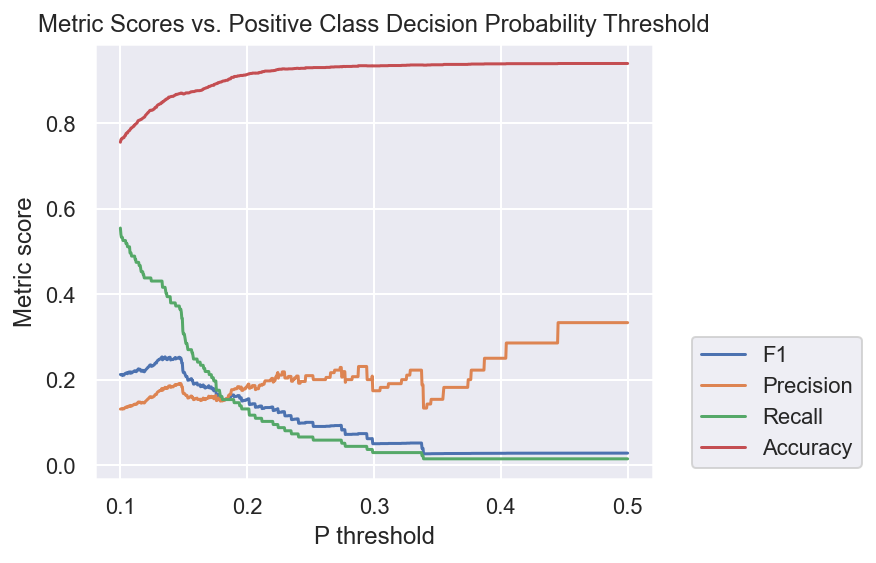

<Figure size 900x600 with 0 Axes>

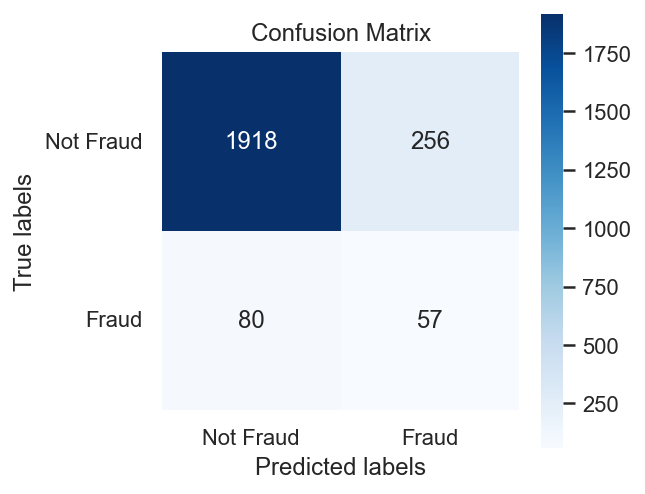

In [31]:
df2 = dataset.copy()

df2 = df2.dropna()

features_list = [
    'Sex', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy'
]

X = df2.loc[:, features_list]
X = pd.get_dummies(X, drop_first=True)
y = df2.loc[:, 'FraudFound_P'].values.ravel()

# Standrazation of feastures.
X = StandardScaler().fit_transform(X)

# Linear dimensionality reduction using Singular Value Decomposition
pca = PCA(n_components='mle', whiten=True)
X_pca = pca.fit_transform(X)

# Linear dimensionality reduction by means of truncated singular value decomposition
# svd = TruncatedSVD()
# X = svd.fit(X).transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_pca,
                                                    y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=101)

lr6 = LogisticRegression(C=1, max_iter=1000)
lr6.fit(X_train, y_train)
lr_scores6 = printScores(lr6, X_test, y_test)

## Change Weights

LogisticRegression Model best F1 score 0.248 at prob decision threshold >= 0.386

F1: 0.248, AUC: 0.645, Log-Loss: 0.266, kappa: 0.181, MCC: 0.200

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2174
           1       0.18      0.41      0.25       137

    accuracy                           0.85      2311
   macro avg       0.57      0.65      0.58      2311
weighted avg       0.91      0.85      0.88      2311



<Figure size 900x600 with 0 Axes>

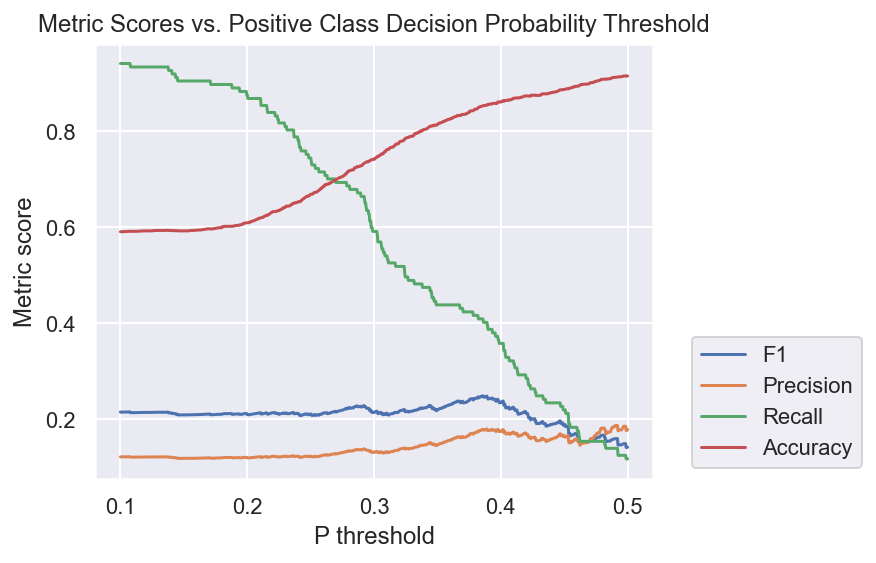

<Figure size 900x600 with 0 Axes>

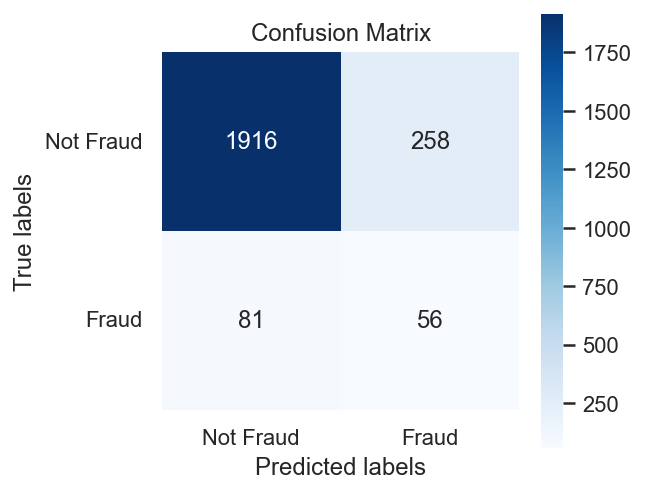

In [34]:
lr3 = LogisticRegression(C=1, max_iter=1000, class_weight={0: 0.2, 1: 0.8})
lr3.fit(X_train, y_train)
lr3_scores = printScores(lr3, X_test, y_test)

LogisticRegression Model best F1 score 0.230 at prob decision threshold >= 0.476

F1: 0.230, AUC: 0.712, Log-Loss: 0.401, kappa: 0.146, MCC: 0.219

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      2174
           1       0.14      0.70      0.23       137

    accuracy                           0.72      2311
   macro avg       0.56      0.71      0.53      2311
weighted avg       0.93      0.72      0.80      2311



<Figure size 900x600 with 0 Axes>

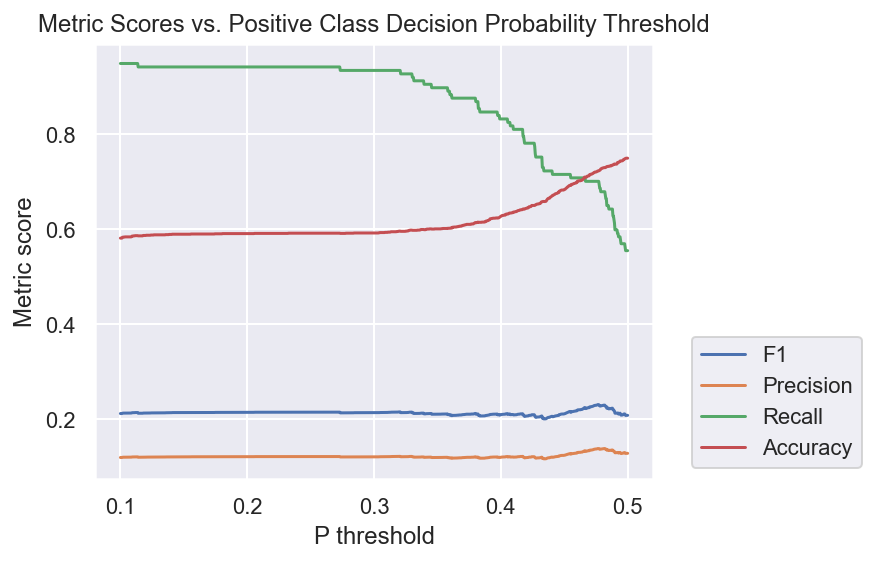

<Figure size 900x600 with 0 Axes>

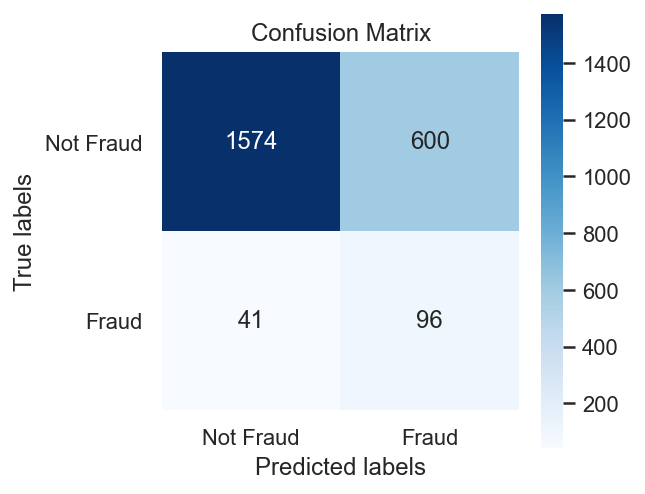

In [14]:
lr2 = LogisticRegression(C=1, max_iter=1000, class_weight={0: 0.1, 1: 0.9})
lr2.fit(X_train, y_train)
lr2_scores = printScores(lr2, X_test, y_test)

In [15]:
from sklearn.utils.class_weight import compute_class_weight
yy = df2.loc[:, 'FraudFound_P']
class_weights = compute_class_weight('balanced', classes=np.unique(yy), y=yy.values)
class_weights

array([0.53151164, 8.43357664])

LogisticRegression Model best F1 score 0.216 at prob decision threshold >= 0.485

F1: 0.216, AUC: 0.754, Log-Loss: 0.550, kappa: 0.124, MCC: 0.241

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2174
           1       0.12      0.93      0.22       137

    accuracy                           0.60      2311
   macro avg       0.56      0.75      0.47      2311
weighted avg       0.94      0.60      0.70      2311



<Figure size 900x600 with 0 Axes>

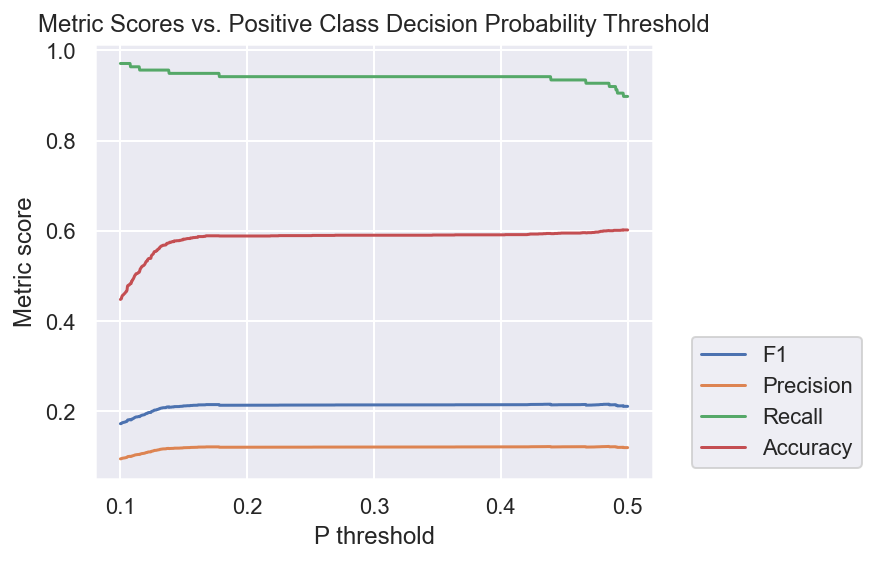

<Figure size 900x600 with 0 Axes>

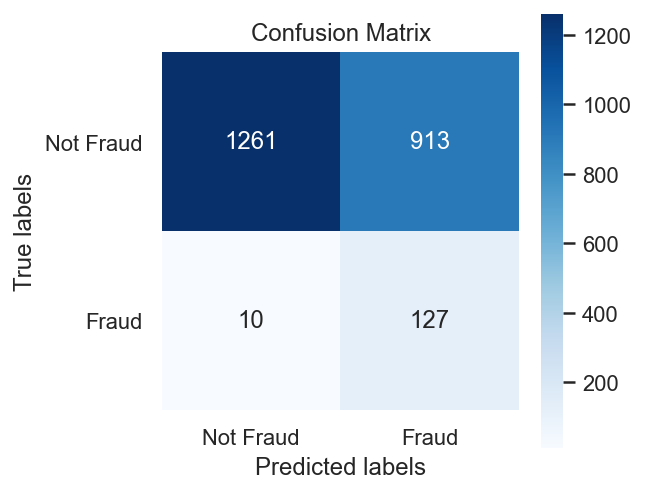

In [16]:
lr0 = LogisticRegression(C=1, max_iter=1000, class_weight={0: class_weights[0], 1: class_weights[1]})
lr0.fit(X_train, y_train)
lr0_scores = printScores(lr0, X_test, y_test)

In [17]:
b = Counter(dataset.FraudFound_P)[0]/Counter(dataset.FraudFound_P)[1]
print(f'{b:.0f}:1')

16:1


LogisticRegression Model best F1 score 0.216 at prob decision threshold >= 0.487

F1: 0.216, AUC: 0.754, Log-Loss: 0.552, kappa: 0.124, MCC: 0.241

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2174
           1       0.12      0.93      0.22       137

    accuracy                           0.60      2311
   macro avg       0.56      0.75      0.47      2311
weighted avg       0.94      0.60      0.70      2311



<Figure size 900x600 with 0 Axes>

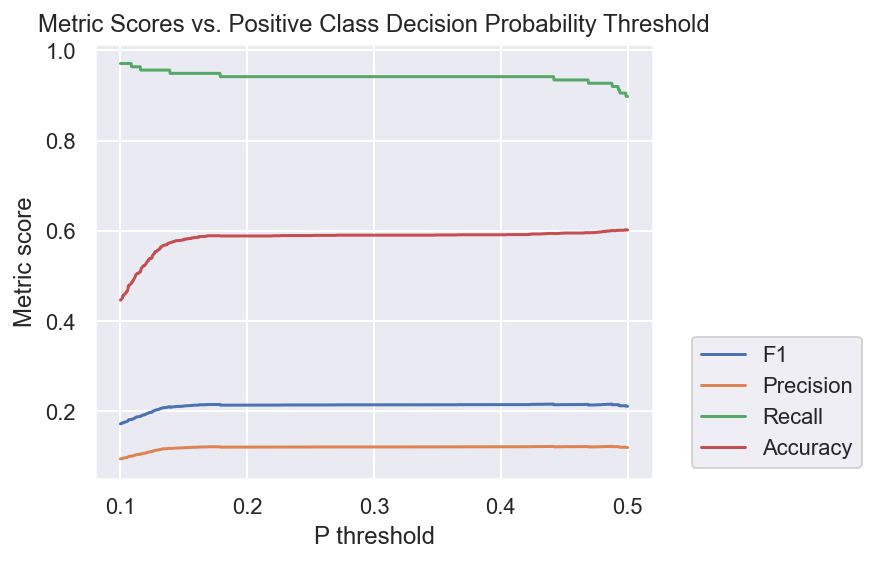

<Figure size 900x600 with 0 Axes>

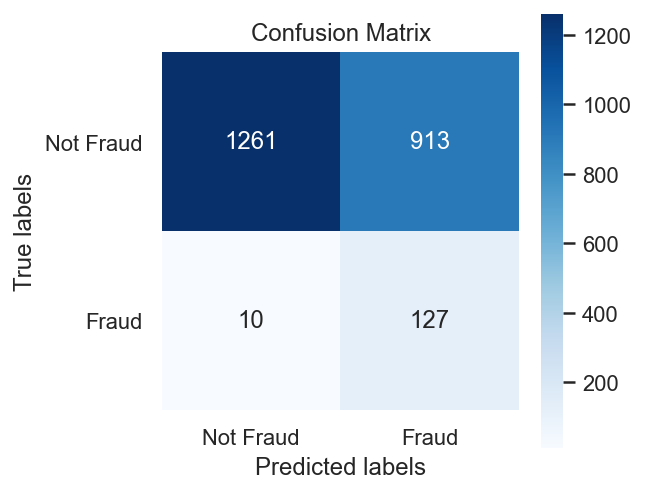

In [18]:
lr00 = LogisticRegression(C=1, max_iter=1000, class_weight={0: 1, 1: 16})
lr00.fit(X_train, y_train)
lr00_scores = printScores(lr00, X_test, y_test)

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
RED = '\033[91m'
DARKCYAN = '\033[36m'
BOLD = '\033[1m'
BLUE = '\033[94m'
END = '\033[0m'

# Handing Imbalanced Classes
__Note:__ SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.
- Over-sampling techniques: Oversampling techniques refer to create artificial minority class points. Some oversampling techniques are Random Over Sampling, ADASYN, SMOTE, etc.
- Under-sampling techniques: Undersampling techniques refer to remove majority class points. Some undersampling techniques are ENN, Random Under Sampling, TomekLinks, etc.
- https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn



## Sklearn Ensamble Classifers (& others) and Resampling Algorithems

In [37]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import imblearn.over_sampling as ov
import imblearn.under_sampling as un
import imblearn.combine as com

X2 = df2.loc[:, features_list]
X2 = pd.get_dummies(X2, drop_first=True)
y2 = df2.loc[:, 'FraudFound_P'].values.ravel()

# X2 = StandardScaler().fit_transform(X2)

# # pca = PCA(n_components='mle', whiten='True')
# pca = PCA(svd_solver='full')
# X2 = pca.fit_transform(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                        y2,
                                                        test_size=.2,
                                                        stratify=y2,
                                                        shuffle=True,
                                                        random_state=101)

clf2 = {"KNeighborsClassifier": KNeighborsClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "ExtraTreesClassifier": ExtraTreesClassifier(),
        "BaggingClassifier": BaggingClassifier(),
        "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100),
        "GradientBoostingClassifier": GradientBoostingClassifier(),
        "SGDClassifier": SGDClassifier(loss='log'),
        "SVC": SVC(kernel='rbf', C=1000, probability=True)
        }

imb_resamplers = {
    "RandomOverSampler": ov.RandomOverSampler(random_state=0),
    "SMOTE": ov.SMOTE(random_state=0),
    "BorderlineSMOTE": ov.BorderlineSMOTE(random_state=0),
    "KMeansSMOTE": ov.KMeansSMOTE(random_state=0),
    "SMOTEN": ov.SMOTEN(random_state=0),
    "ADASYN": ov.ADASYN(random_state=0),
    "SVMSMOTE": ov.SVMSMOTE(random_state=0),
    
    "SMOTETomek": com.SMOTETomek(random_state=0),
    "SMOTEENN": com.SMOTEENN(random_state=0),

    "RandomUnderSampler": un.RandomUnderSampler(random_state=0),
    "TomekLinks": un.TomekLinks(),
    "EditedNearestNeighbours": un.EditedNearestNeighbours(),
    "AllKNN": un.AllKNN(),
    "ClusterCentroids": un.ClusterCentroids(random_state=0),
#     "CondensedNearestNeighbour": un.CondensedNearestNeighbour(random_state=0),    
    "InstanceHardnessThreshold": un.InstanceHardnessThreshold(random_state=0),
    "NearMiss": un.NearMiss(),
    "NeighbourhoodCleaningRule": un.NeighbourhoodCleaningRule(),
    "OneSidedSelection": un.OneSidedSelection(random_state=0),
    "RepeatedEditedNearestNeighbours": un.RepeatedEditedNearestNeighbours(),
}

for clf in clf2:
    print("__"*50)
    print(BOLD + RED + clf + END)

    for key in imb_resamplers:
        try:
            print(key)
            classifier = imb_resamplers[key]
            X2_resampled, y2_resampled = classifier.fit_resample(X2_train, y2_train)

            model = clf2[clf]
            model.fit(X2_resampled, y2_resampled)
            printScores(model, X2_test, y2_test, plots=False)
        except Exception as e:
            print(key, "->", e)

____________________________________________________________________________________________________
KNeighborsClassifier
RandomOverSampler

F1: 0.233, AUC: 0.696, Log-Loss: 3.061, kappa: 0.151, MCC: 0.211

SMOTE

F1: 0.204, AUC: 0.640, Log-Loss: 2.551, kappa: 0.122, MCC: 0.159

BorderlineSMOTE

F1: 0.212, AUC: 0.678, Log-Loss: 2.353, kappa: 0.126, MCC: 0.185

KMeansSMOTE
KMeansSMOTE -> No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.
SMOTEN

F1: 0.196, AUC: 0.677, Log-Loss: 2.360, kappa: 0.104, MCC: 0.174

ADASYN

F1: 0.233, AUC: 0.684, Log-Loss: 2.645, kappa: 0.152, MCC: 0.204

SVMSMOTE

F1: 0.240, AUC: 0.663, Log-Loss: 1.840, kappa: 0.165, MCC: 0.200

SMOTETomek

F1: 0.204, AUC: 0.640, Log-Loss: 2.551, kappa: 0.122, MCC: 0.159

SMOTEENN

F1: 0.240, AUC: 0.706, Log-Loss: 4.795, kappa: 0.158, MCC: 0.221

RandomUnderSampler

F1: 0.192, AUC: 0.685, Log-Loss: 2.334, kappa: 0.099, MCC: 0.178

TomekLinks



F1: 0.241, AUC: 0.669, Log-Loss: 1.226, kappa: 0.165, MCC: 0.203

AllKNN

F1: 0.255, AUC: 0.681, Log-Loss: 1.604, kappa: 0.181, MCC: 0.220

ClusterCentroids

F1: 0.172, AUC: 0.680, Log-Loss: 6.910, kappa: 0.072, MCC: 0.172

InstanceHardnessThreshold

F1: 0.242, AUC: 0.753, Log-Loss: 3.260, kappa: 0.157, MCC: 0.252

NearMiss

F1: 0.110, AUC: 0.493, Log-Loss: 8.258, kappa: -0.002, MCC: -0.034

NeighbourhoodCleaningRule

F1: 0.255, AUC: 0.681, Log-Loss: 1.163, kappa: 0.181, MCC: 0.220

OneSidedSelection

F1: 0.257, AUC: 0.684, Log-Loss: 0.774, kappa: 0.183, MCC: 0.223

RepeatedEditedNearestNeighbours

F1: 0.240, AUC: 0.745, Log-Loss: 2.787, kappa: 0.155, MCC: 0.246

____________________________________________________________________________________________________
AdaBoostClassifier
RandomOverSampler

F1: 0.215, AUC: 0.757, Log-Loss: 0.686, kappa: 0.122, MCC: 0.244

SMOTE

F1: 0.210, AUC: 0.728, Log-Loss: 0.682, kappa: 0.119, MCC: 0.218

BorderlineSMOTE

F1: 0.213, AUC: 0.744, Log-Loss:

## Imbalanced Learn API Classifiers

In [21]:
import imblearn.ensemble as en

X2 = df2.loc[:, features_list]
X2 = pd.get_dummies(X2, drop_first=True)
y2 = df2.loc[:, 'FraudFound_P'].values.ravel()

# X2 = StandardScaler().fit_transform(X2)

# # pca = PCA(n_components='mle', whiten='True')
# pca = PCA(svd_solver='full')
# X2 = pca.fit_transform(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                        y2,
                                                        test_size=.2,
                                                        stratify=y2,
                                                        shuffle=True,
                                                        random_state=101)

imb_classifiers = {
    "BalancedBaggingClassifier": en.BalancedBaggingClassifier(n_estimators=50, sampler=SMOTEENN(random_state=0), random_state=0),
    "BalancedRandomForestClassifier": en.BalancedRandomForestClassifier(random_state=0),
    "EasyEnsembleClassifier": en.EasyEnsembleClassifier(n_estimators=100, random_state=0),
    "RUSBoostClassifier": en.RUSBoostClassifier(n_estimators=100, random_state=0),
}

for key in imb_classifiers:
    print("__"*50)
    print(key)
    classifier = imb_classifiers[key]
    model = classifier.fit(X2_train, y2_train)
    printScores(model, X2_test, y2_test, plots=False)

____________________________________________________________________________________________________
BalancedBaggingClassifier

F1: 0.264, AUC: 0.628, Log-Loss: 0.459, kappa: 0.208, MCC: 0.213

____________________________________________________________________________________________________
BalancedRandomForestClassifier

F1: 0.233, AUC: 0.761, Log-Loss: 0.586, kappa: 0.146, MCC: 0.253

____________________________________________________________________________________________________
EasyEnsembleClassifier

F1: 0.213, AUC: 0.757, Log-Loss: 0.682, kappa: 0.121, MCC: 0.243

____________________________________________________________________________________________________
RUSBoostClassifier

F1: 0.215, AUC: 0.757, Log-Loss: 0.687, kappa: 0.122, MCC: 0.244



In [22]:
# plt.figure(figsize=(10, 30))
# perm_importance = permutation_importance(lr4, X2_test, y2_test)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X2_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

# XGBoost

XGBClassifier Model best F1 score 0.269 at prob decision threshold >= 0.152

F1: 0.269, AUC: 0.644, Log-Loss: 0.183, kappa: 0.209, MCC: 0.220

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2174
           1       0.21      0.38      0.27       137

    accuracy                           0.88      2311
   macro avg       0.58      0.64      0.60      2311
weighted avg       0.91      0.88      0.89      2311



<Figure size 900x600 with 0 Axes>

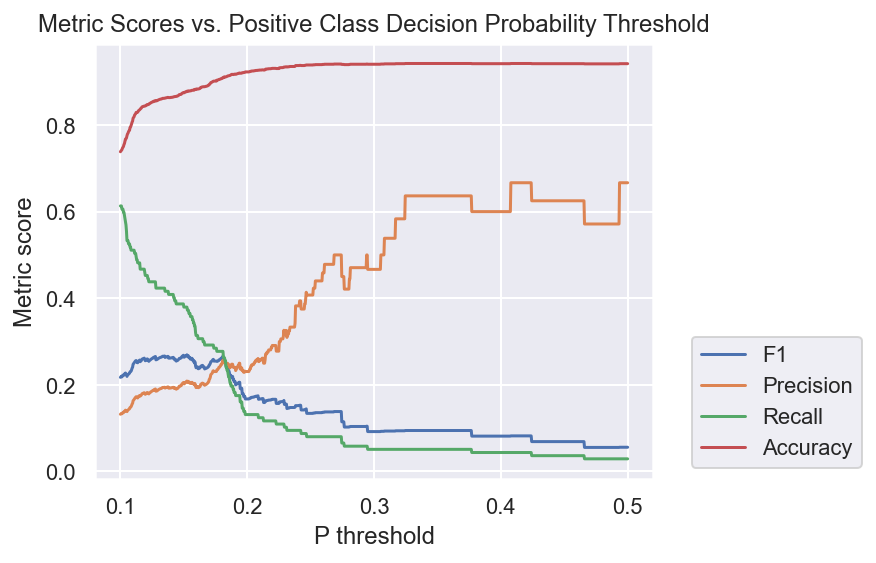

<Figure size 900x600 with 0 Axes>

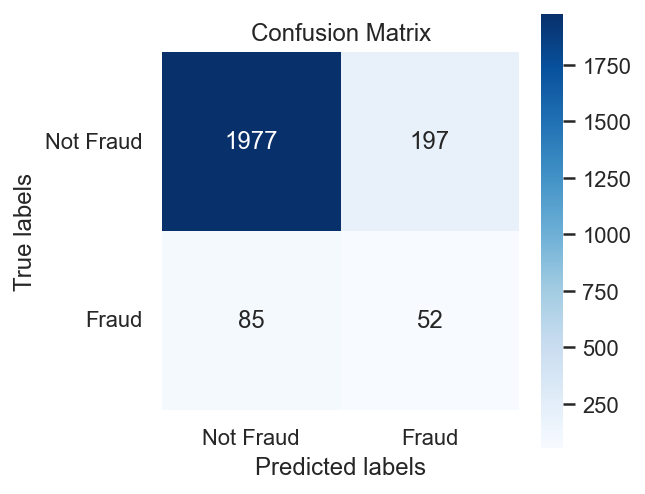

In [18]:
df5 = dataset.copy()

df5 = df5.dropna()

features_list = [
    'Sex', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'DriverRating',
    'Days_Policy_Accident', 'PastNumberOfClaims',
    'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent',
    'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy'
]

X5 = df5.loc[:, features_list]
X5 = pd.get_dummies(X5, drop_first=True)
y5 = df5.loc[:, 'FraudFound_P'].values.ravel()

# X5 = StandardScaler().fit_transform(X5)
# X5 = PCA().fit_transform(X5)



X5, X5_test, y5, y5_test = train_test_split(X5,
                                            y5,
                                            test_size=.2,
                                            stratify=y5,
                                            random_state=1)

X5_train, X5_val, y5_train, y5_val = train_test_split(X5,
                                                      y5,
                                                      test_size=.25,
                                                      stratify=y5,
                                                      random_state=2)


# X5_resampled, y5_resampled = SMOTEENN(random_state=3).fit_resample(X5_train, y5_train)

gbm = xgboost.XGBClassifier(
    n_estimators=30000,
    max_depth=4,
    objective='binary:logistic',
    learning_rate=.01,
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8,
    use_label_encoder=False,
#     scale_pos_weight= 3#Counter(dataset.FraudFound_P)[0]/Counter(dataset.FraudFound_P)[1]
)

eval_set = [(X5_train, y5_train), (X5_val, y5_val)]
fit_model = gbm.fit(
    X5_train, y5_train,
    eval_set=eval_set,   # new evaluation metric: classification error (could also use AUC, e.g.)
    eval_metric='logloss',
    early_stopping_rounds=50,
    verbose=False)

# print('Accuracy %.3f' % accuracy_score(
#     y5_test, gbm.predict(X5_test, ntree_limit=gbm.best_ntree_limit)))

xgb_scores = printScores(gbm, X5_test, y5_test)

In [24]:
gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'DriverRating': 378.0,
 'Sex_Male': 224.0,
 'Fault_Third Party': 539.0,
 'PolicyType_Sedan - Collision': 275.0,
 'PolicyType_Sedan - Liability': 95.0,
 'PolicyType_Sport - Collision': 88.0,
 'PolicyType_Utility - All Perils': 31.0,
 'VehicleCategory_Sport': 71.0,
 'VehicleCategory_Utility': 27.0,
 'VehiclePrice_30000 to 39000': 147.0,
 'VehiclePrice_40000 to 59000': 70.0,
 'VehiclePrice_less than 20000': 117.0,
 'VehiclePrice_more than 69000': 242.0,
 'Days_Policy_Accident_more than 30': 73.0,
 'PastNumberOfClaims_2 to 4': 217.0,
 'PastNumberOfClaims_more than 4': 117.0,
 'PastNumberOfClaims_none': 149.0,
 'AgeOfVehicle_4 years': 66.0,
 'AgeOfVehicle_5 years': 61.0,
 'AgeOfVehicle_6 years': 76.0,
 'AgeOfVehicle_7 years': 210.0,
 'AgeOfVehicle_more than 7': 421.0,
 'AgeOfVehicle_new': 14.0,
 'PoliceReportFiled_Yes': 102.0,
 'NumberOfSuppliments_3 to 5': 52.0,
 'NumberOfSuppliments_more than 5': 150.0,
 'NumberOfSuppliments_none': 203.0,
 'AddressChange_Claim_2 to 3 years': 478.0,
 'Add

In [25]:
def xgboost_search(X, y, search_verbose=1):
    params = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = xgboost.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)
    grid_search.fit(X, y)
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)
    return grid_search.best_params_

In [28]:
model_params = xgboost_search(X5_train, y5_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=1.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.79


In [29]:
xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
              
Parameters=  {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 100, 'subsample': 1.0}

In [ ]:
modelxgb = xgboost.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
modelxgb.set_params(**model_params)
modelxgb.fit(X5_train, y5_train)
printScores(modelxgb, X5_test, y5_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

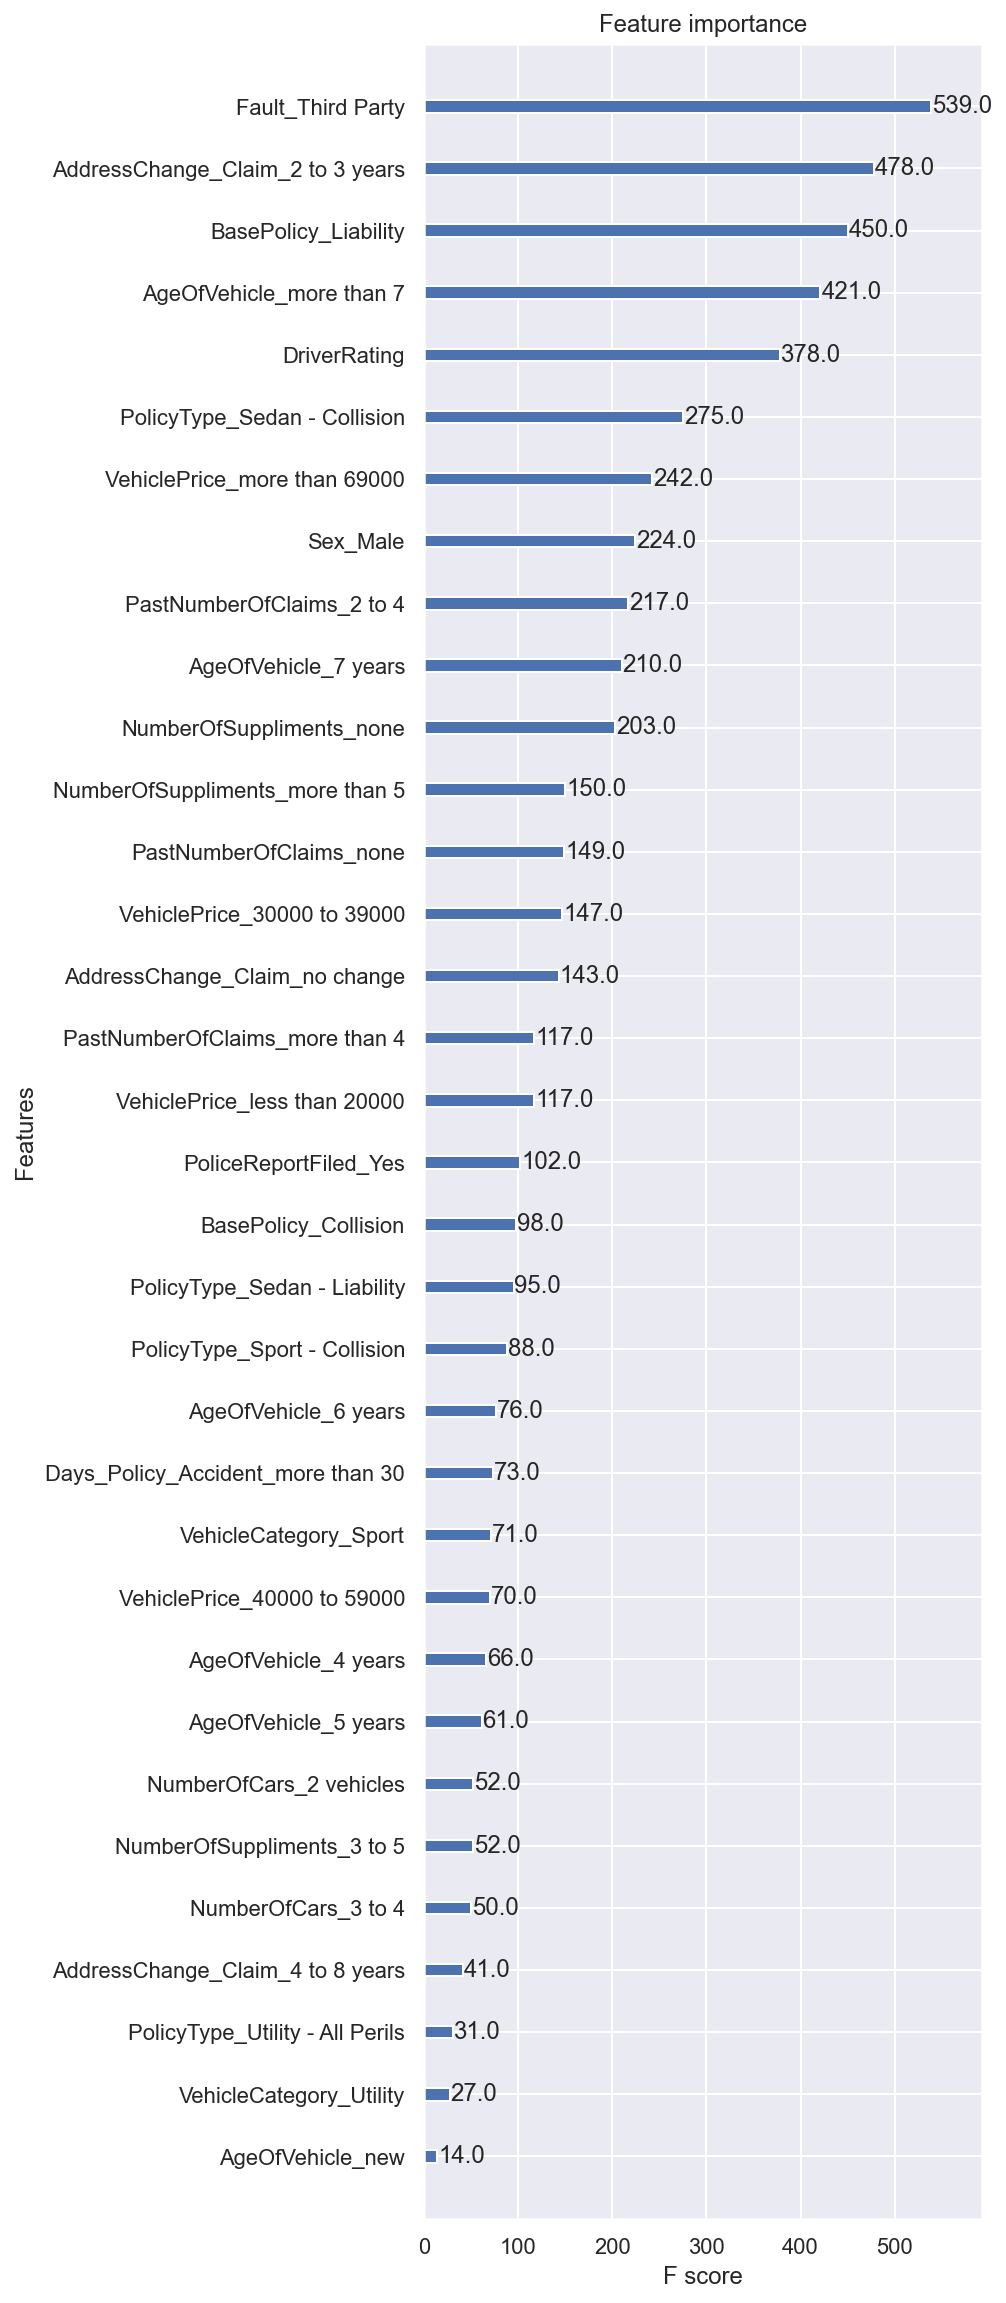

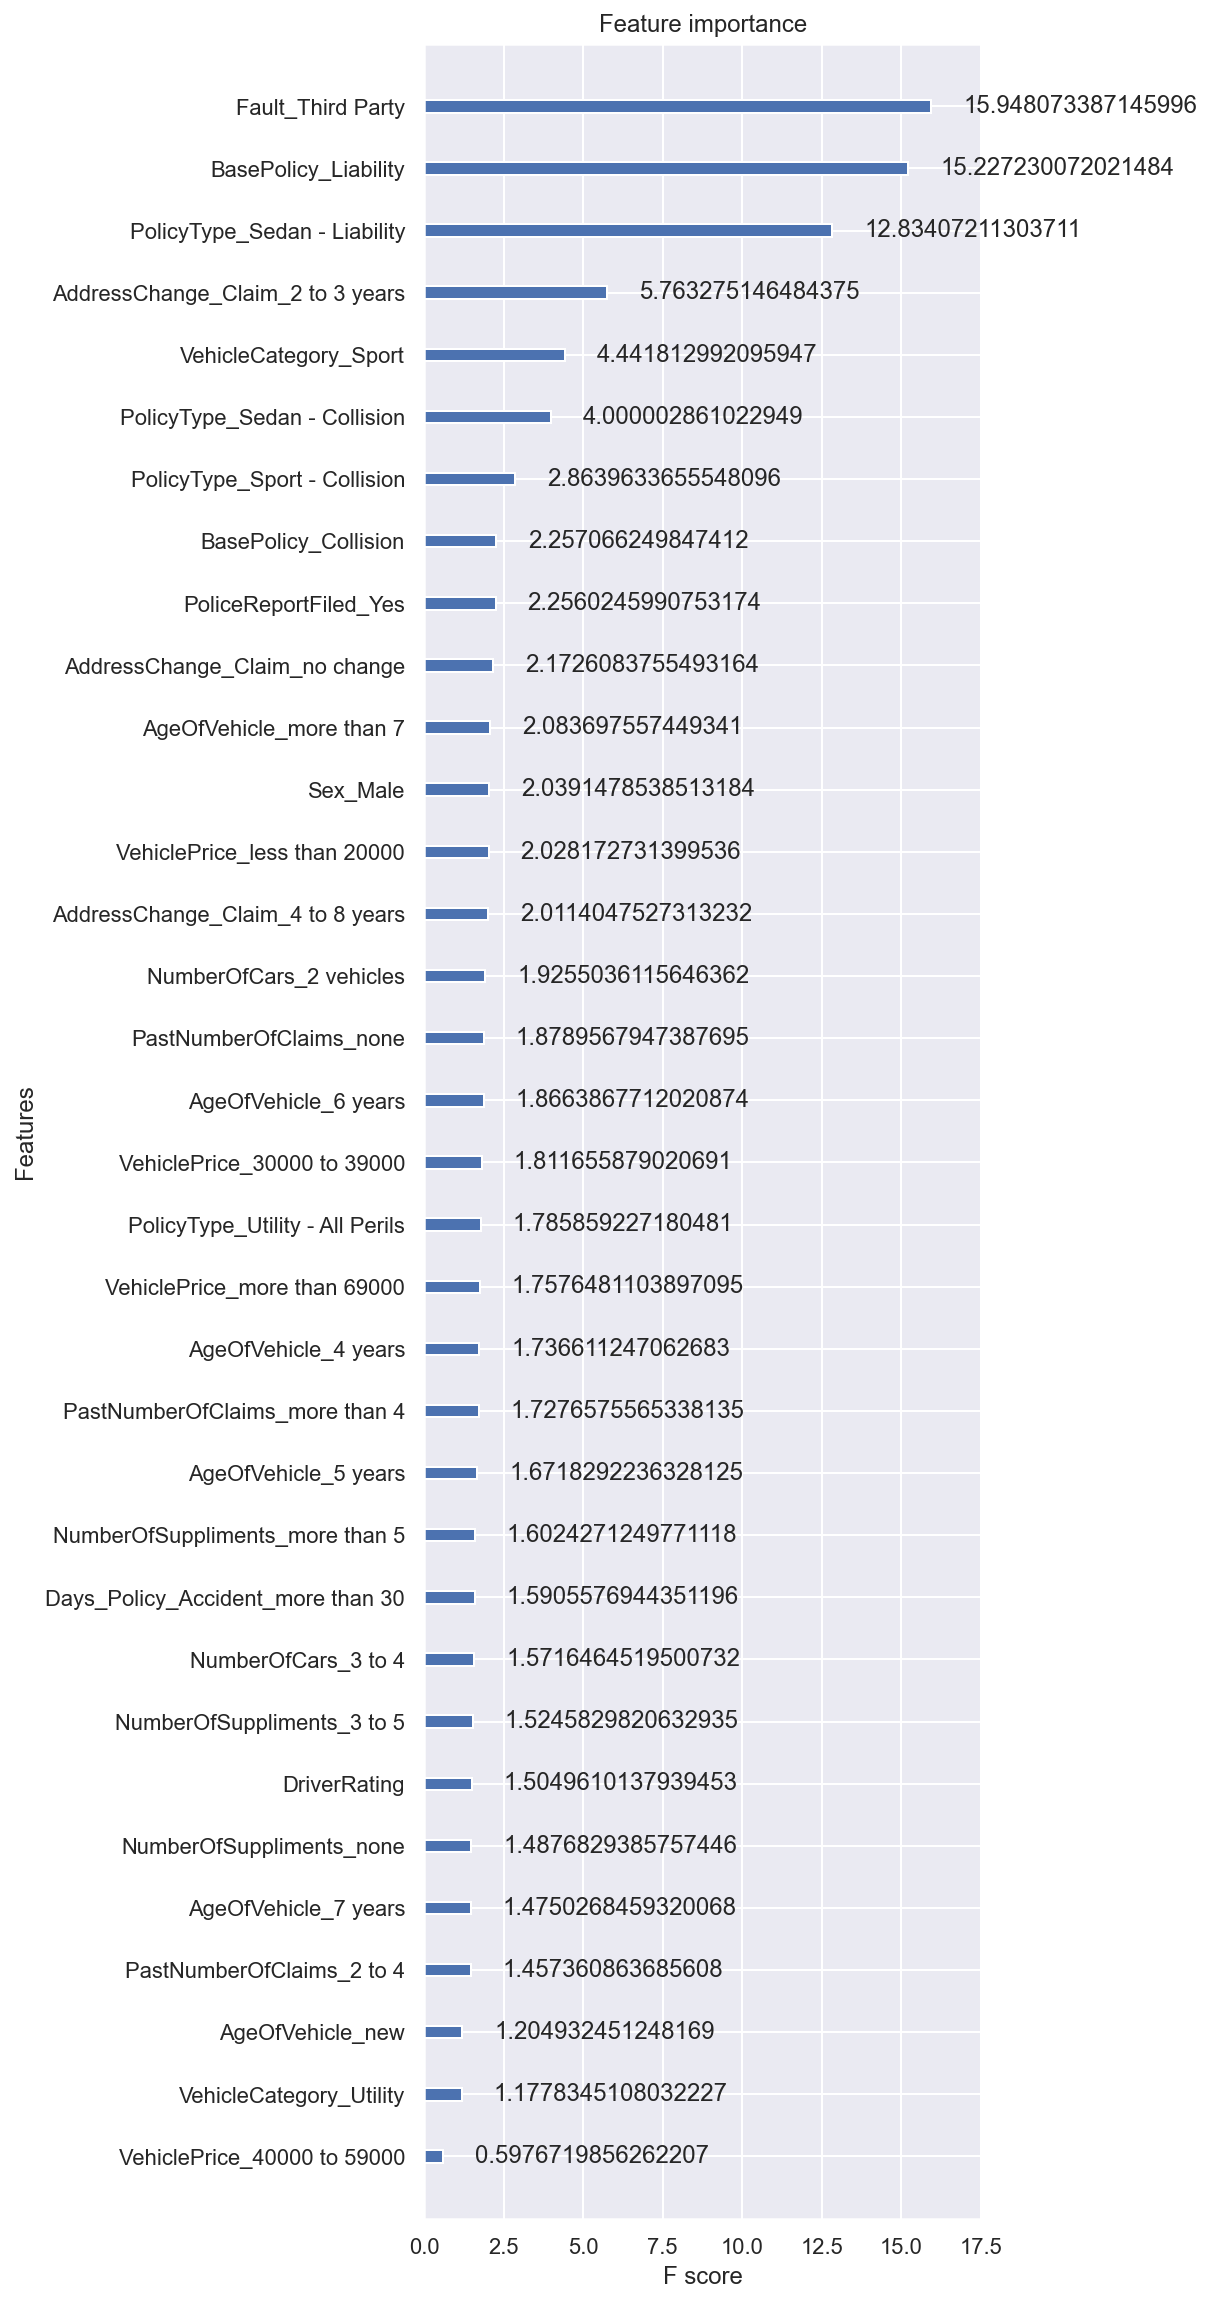

In [31]:
figsize(5,20)
xgboost.plot_importance(gbm)
xgboost.plot_importance(gbm, importance_type='gain')

In [33]:
# model.save_model("my_xgboost.json")

# Support Vector Machine

SVC Model best F1 score 0.188 at prob decision threshold >= 0.367

F1: 0.188, AUC: 0.573, Log-Loss: 0.467, kappa: 0.131, MCC: 0.132

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2174
           1       0.17      0.21      0.19       137

    accuracy                           0.89      2311
   macro avg       0.56      0.57      0.57      2311
weighted avg       0.90      0.89      0.90      2311



<Figure size 900x600 with 0 Axes>

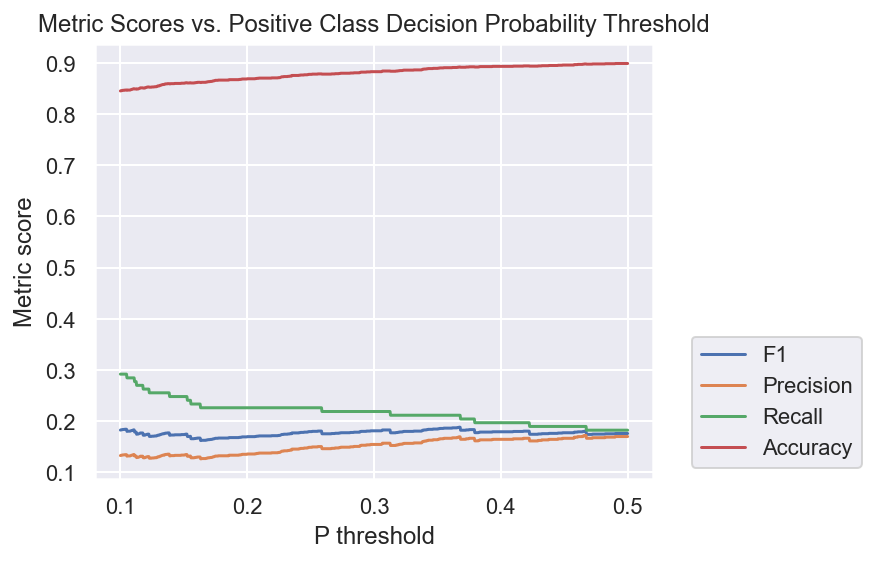

<Figure size 900x600 with 0 Axes>

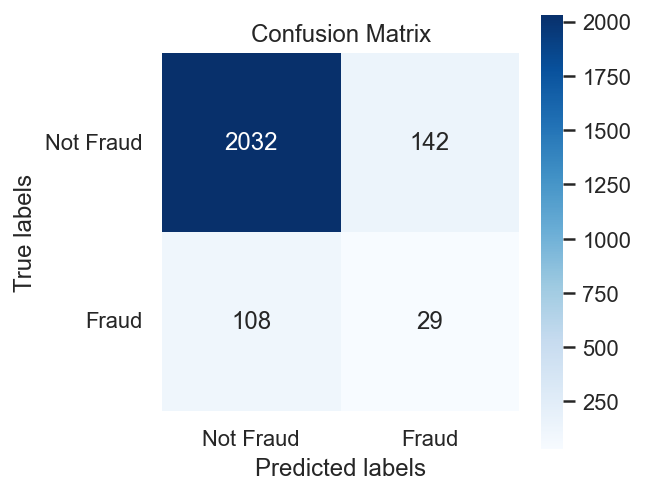

In [20]:
df20 = dataset.copy()

df20 = df20.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X20 = df20.loc[:, features_list]
y20 = df20.loc[:, 'FraudFound_P'].values.ravel()

X20.Sex = np.where(X20.Sex == 'Male', 1, 0)
X20 = pd.get_dummies(X20, drop_first=True)

pca = PCA(n_components='mle', whiten='True')
X20 = pca.fit(X20).transform(X20)


X20_train, X20_test, y20_train, y20_test = train_test_split(X20,
                                                            y20,
                                                            test_size=.2,
                                                            stratify=y20,
                                                            random_state=101)

X20_resampled, y20_resampled = SMOTETomek(random_state=3).fit_resample(X20_train, y20_train)


svm = SVC(kernel='rbf', C=1000, probability=True)
svm.fit(X20_resampled, y20_resampled)
svm_scores = printScores(svm, X20_test, y20_test, probability=True)

# Gaussian Naive Bayes

Using PCA & SMOTE + ENN

GaussianNB Model best F1 score 0.165 at prob decision threshold >= 0.290

F1: 0.165, AUC: 0.564, Log-Loss: 1.474, kappa: 0.098, MCC: 0.102

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2174
           1       0.13      0.22      0.16       137

    accuracy                           0.87      2311
   macro avg       0.54      0.56      0.55      2311
weighted avg       0.90      0.87      0.88      2311



<Figure size 900x600 with 0 Axes>

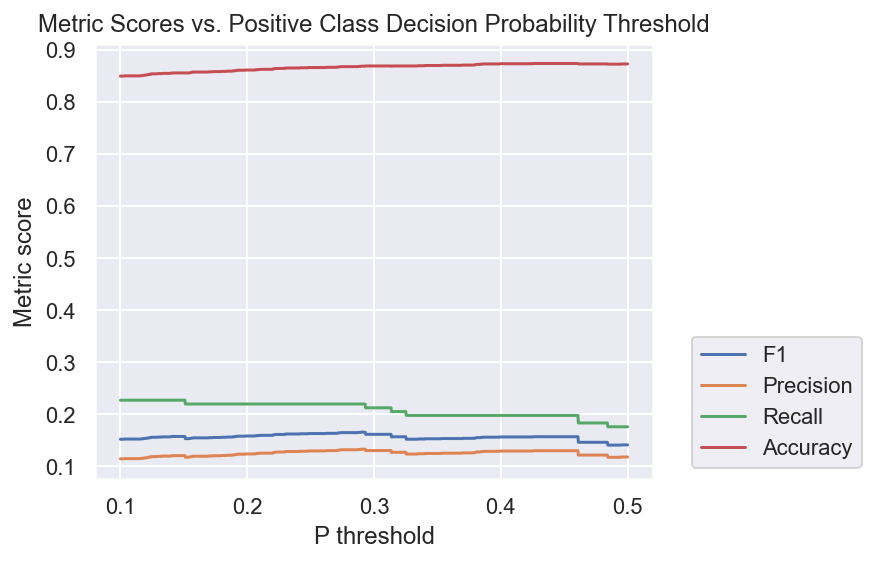

<Figure size 900x600 with 0 Axes>

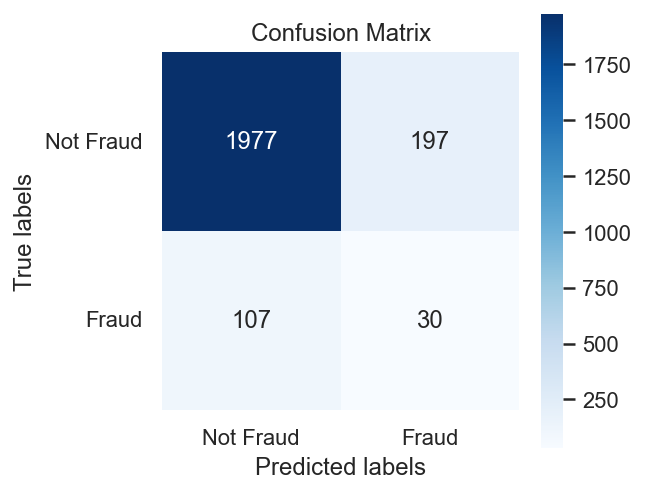

In [25]:
df25 = dataset.copy()

df25 = df25.dropna()

features_list = [
    'Sex', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'DriverRating',
    'Days_Policy_Accident', 'PastNumberOfClaims',
    'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent',
    'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy'
]

X25 = df25.loc[:, features_list]
X25 = pd.get_dummies(X25, drop_first=True)
y25 = df25.loc[:, 'FraudFound_P'].values.ravel()

X25 = StandardScaler().fit_transform(X25)
X25 = PCA().fit_transform(X25)



X25_train, X25_test, y25_train, y25_test = train_test_split(X25,
                                            y25,
                                            test_size=.2,
                                            stratify=y25,
                                            random_state=1)
Gaussian = GaussianNB()
Gaussian.fit(X25_train, y25_train)
gnb_scores = printScores(Gaussian, X25_test, y25_test)

Pipeline Model best F1 score 0.251 at prob decision threshold >= 0.316

F1: 0.251, AUC: 0.648, Log-Loss: 0.263, kappa: 0.183, MCC: 0.203

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2174
           1       0.18      0.42      0.25       137

    accuracy                           0.85      2311
   macro avg       0.57      0.65      0.58      2311
weighted avg       0.91      0.85      0.88      2311



<Figure size 900x600 with 0 Axes>

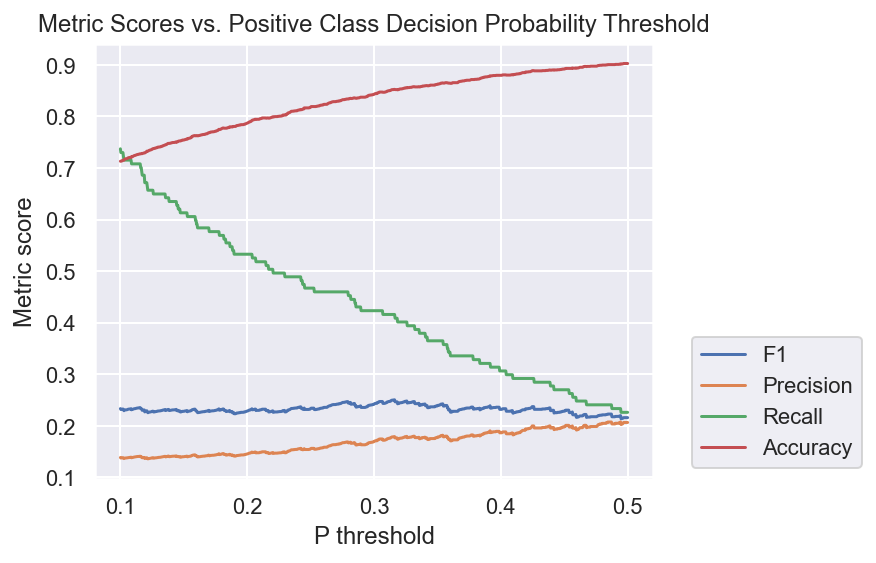

<Figure size 900x600 with 0 Axes>

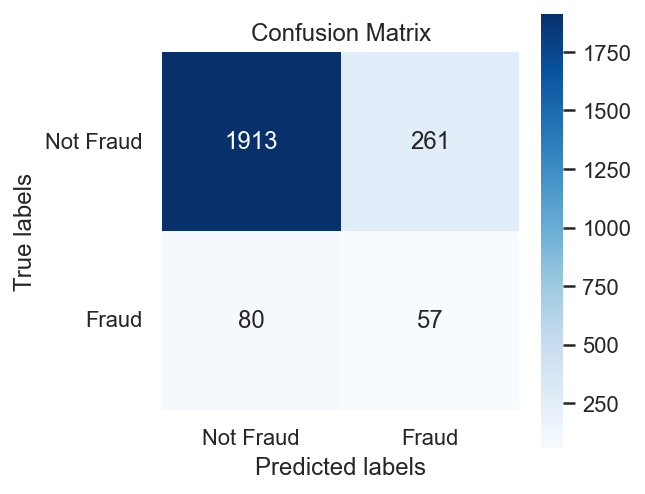

In [26]:
df25 = dataset.copy()

df25 = df25.dropna()

features_list = [
    'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
    'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
    'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent',
    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy', 'ClaimSize'
]

X40 = df25.loc[:, features_list]
X40 = pd.get_dummies(X40, drop_first=True)
y40 = df25.loc[:, 'FraudFound_P'].values.ravel()



X40_resampled, y40_resampled = SMOTEENN(random_state=3).fit_resample(X40, y40)

X40_train, X40_test, y40_train, y40_test = train_test_split(X40,
                                                            y40,
                                                            test_size=.2,
                                                            stratify=y40,
                                                            random_state=101)

SGD = make_pipeline(StandardScaler(), SGDClassifier(loss='log', random_state=9))
SGD.fit(X40_resampled, y40_resampled)

SGD_scores = printScores(SGD, X40_test, y40_test, probability=True)

# Voting Classifier

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from mlxtend.classifier import StackingClassifier
import pickle

names = [
    "Nearest Neighbors",
    "SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    #"Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(1),
    SVC(C=1, probability=True, random_state=3),
    DecisionTreeClassifier(),
    RandomForestClassifier( random_state=3),
    MLPClassifier(alpha=1, max_iter=1000, random_state=3),
    #GaussianNB(),
]
model_list = list(zip(names, classifiers))

df30 = dataset.copy()

df30 = df30.dropna()

X30 = df30.loc[:, features_list]
y30 = df30.loc[:, 'FraudFound_P'].values.ravel()
X30 = pd.get_dummies(X30, drop_first=True)

X30 = StandardScaler().fit_transform(X30)
X30 = PCA().fit_transform(X30)


X30_train, X30_test, y30_train, y30_test = train_test_split(
    X30,
    y30,
    test_size=.2,
    stratify=y30,
    shuffle=True,
    random_state=101)

X30_resampled, y30_resampled = SMOTETomek(random_state=3).fit_resample(X30_train, y30_train)

## Average Voting

VotingClassifier Model best F1 score 0.243 at prob decision threshold >= 0.325

F1: 0.243, AUC: 0.667, Log-Loss: 0.272, kappa: 0.169, MCC: 0.204

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2174
           1       0.16      0.50      0.24       137

    accuracy                           0.82      2311
   macro avg       0.56      0.67      0.57      2311
weighted avg       0.92      0.82      0.86      2311



<Figure size 900x600 with 0 Axes>

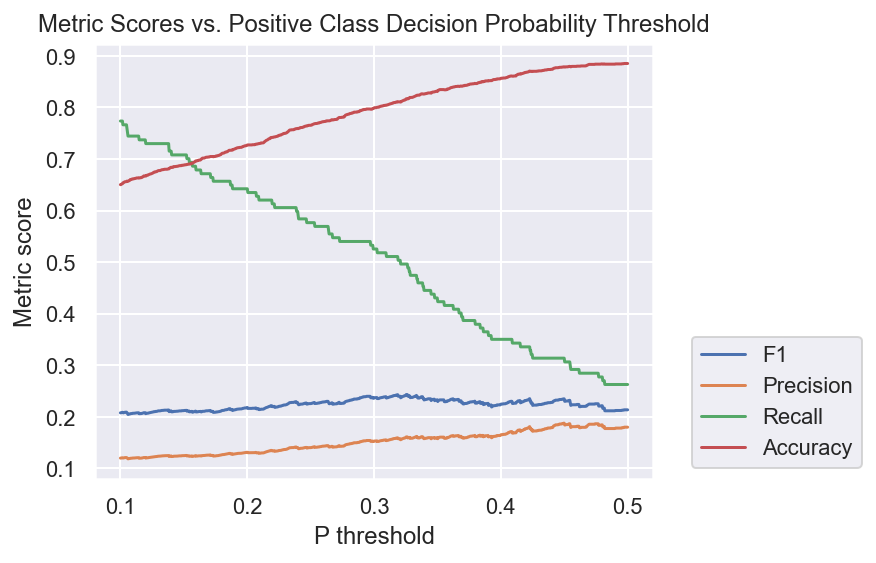

<Figure size 900x600 with 0 Axes>

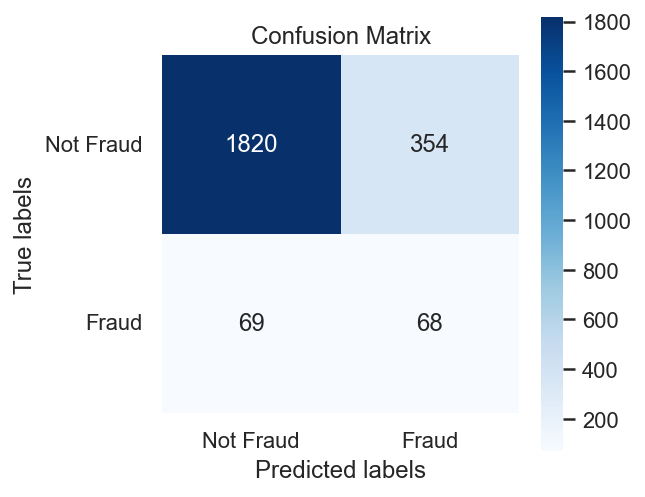

In [28]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft',
                                    n_jobs=-1)

voting_classifer.fit(X30_resampled, y30_resampled)
vca_scores = printScores(voting_classifer, X30_test, y30_test, probability=True)

## Max Voting


              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2174
           1       0.19      0.32      0.24       137

    accuracy                           0.88      2311
   macro avg       0.57      0.62      0.59      2311
weighted avg       0.91      0.88      0.89      2311



<Figure size 900x600 with 0 Axes>

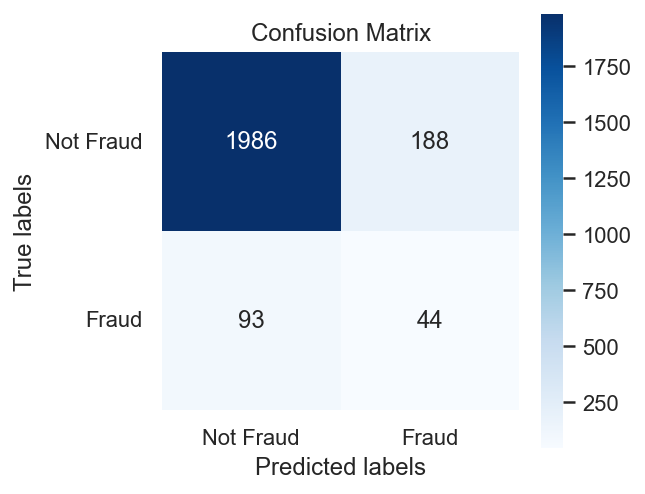

In [38]:
voting_classifer2 = VotingClassifier(estimators=model_list,
                                    voting='hard',
                                    n_jobs=-1)

voting_classifer2.fit(X30_resampled, y30_resampled)
vcm_scores = printScores(voting_classifer2, X30_test, y30_test, probability=False)

## Trying Pre-trained Models
__Those models take only 2 features which explains why they're under-fitted__

In [39]:
# Load pre-trained/tuned models

model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]

X30_test_pca = StandardScaler().fit_transform(X30_test)
pca2 = PCA(n_components=2)
X30_test_pca = pca2.fit_transform(X30_test_pca)

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X30_test_pca, y30_test)}')
    printScores(curr_model, X30_test_pca, y30_test, model_name=model_name, plots=False)

lr_model score: 0.5564690610125487

F1: 0.111, AUC: 0.498, Log-Loss: 0.798, kappa: -0.001, MCC: -0.007

knn_model score: 0.796192124621376

F1: 0.102, AUC: 0.486, Log-Loss: 2.102, kappa: -0.006, MCC: -0.013

rf_model score: 0.7866724361748161

F1: 0.108, AUC: 0.513, Log-Loss: 0.950, kappa: 0.009, MCC: 0.013

et_model score: 0.7754218952834271

F1: 0.104, AUC: 0.494, Log-Loss: 1.024, kappa: -0.003, MCC: -0.006



# Stacking Classifier

StackingClassifier Model best F1 score 0.234 at prob decision threshold >= 0.391

F1: 0.234, AUC: 0.606, Log-Loss: 0.511, kappa: 0.177, MCC: 0.180

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2174
           1       0.20      0.28      0.23       137

    accuracy                           0.89      2311
   macro avg       0.58      0.61      0.59      2311
weighted avg       0.91      0.89      0.90      2311



<Figure size 900x600 with 0 Axes>

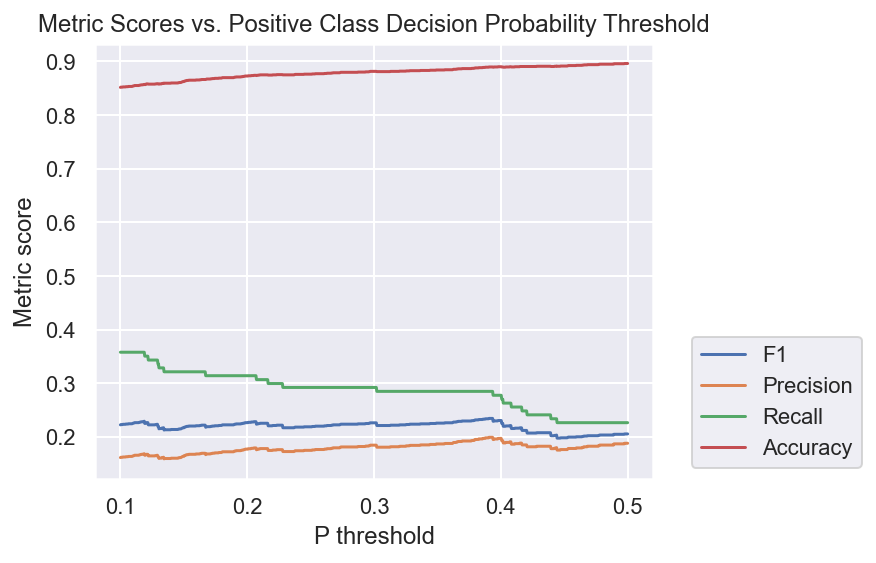

<Figure size 900x600 with 0 Axes>

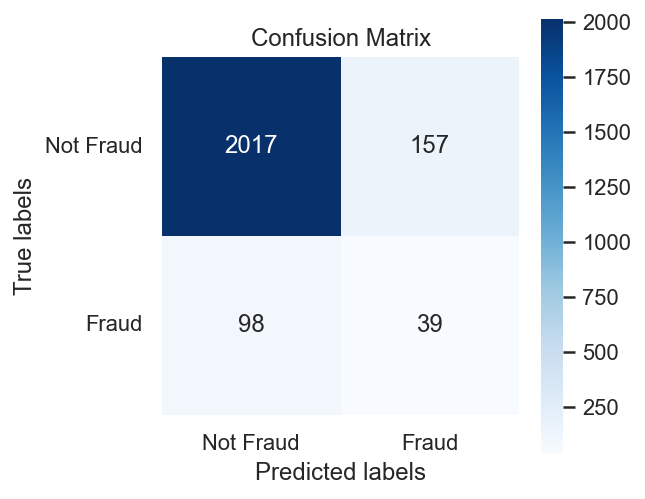

In [40]:
stacked = StackingClassifier(
    classifiers=classifiers, meta_classifier=LogisticRegression(), use_probas=True)

stacked.fit(X30_resampled, y30_resampled)
sc_scores = printScores(stacked, X30_test, y30_test, probability=True)

StackingClassifier Model best F1 score 0.819 at prob decision threshold >= 0.498

F1: 0.819, AUC: 0.912, Log-Loss: 0.107, kappa: 0.807, MCC: 0.807

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10869
           1       0.80      0.84      0.82       685

    accuracy                           0.98     11554
   macro avg       0.90      0.91      0.90     11554
weighted avg       0.98      0.98      0.98     11554



(0.818830242510699,
 0.9123997601159932,
 0.10678808869687027,
 0.8073732668287946)

<Figure size 900x600 with 0 Axes>

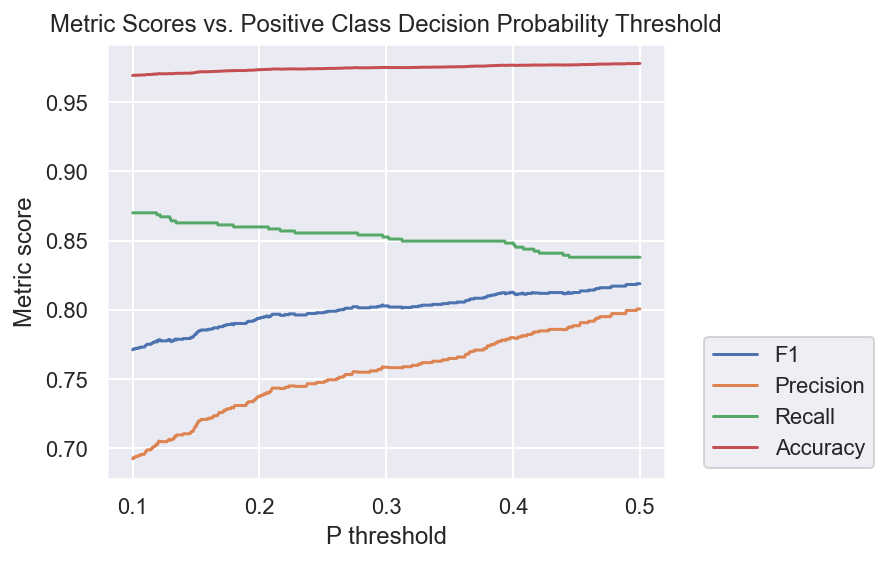

<Figure size 900x600 with 0 Axes>

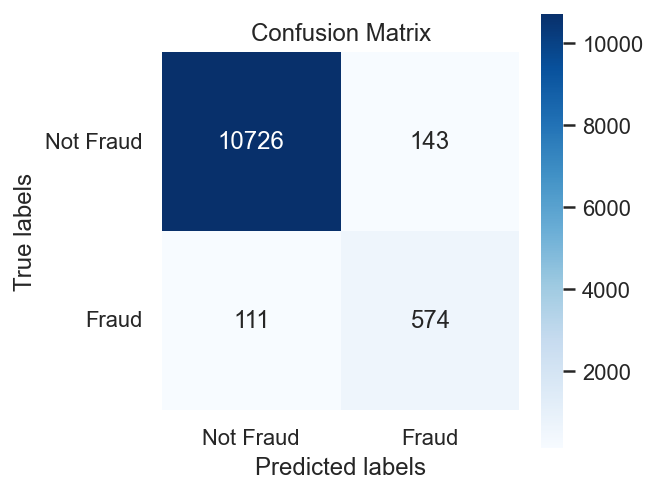

In [41]:
printScores(stacked, X30, y30, probability=True)

In [ ]:
# Results Summary

In [ ]:
# df_sum = pd.DataFrame(data=[
#     lr4_scores, knn_scores, RC_scores, xgb_scores, svm_scores, gnb_scores,
#     vca_scores, vcm_scores, sc_scores
# ],
#     index=[
#     'Logistic Regression', 'KNN', 'Random Forest',
#     'XGBoost', 'SVM', 'Gaussian Naive Bayes',
#     'Voting Classifier - Average Voing',
#     'Voting Classifier - Max Voing',
#     'Stacking Classifier'
# ],
#     columns=['f1', 'AUC', 'Log Loss', 'MCC'])

# df_sum.style.format(formatter={
#     'f1': "{:.1%}",
#     'AUC': "{:.1%}",
#     'Log Loss': "{:.2f}",
#     'MCC': "{:.2f}"
# }).background_gradient(
#     subset=['f1', 'AUC', 'MCC'],
#     cmap='Reds',
# ).background_gradient(
#     subset=['Log Loss'],
#     cmap='Reds_r',
# )
# df_sum

# Imbalance-Xgboost API
https://github.com/jhwjhw0123/Imbalance-XGBoost

In [42]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import GridSearchCV

In [43]:
df56 = dataset.copy()

df56 = df56.dropna()

features_list = [
    'Sex', 'Fault', 'PolicyType', 'VehicleCategory',
    'VehiclePrice', 'DriverRating',
    'Days_Policy_Accident', 'PastNumberOfClaims',
    'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent',
    'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
    'BasePolicy'
]

X56 = df56.loc[:, features_list]
X56 = pd.get_dummies(X56, drop_first=True)
y56 = df56.loc[:, 'FraudFound_P'].values.ravel()

X56 = StandardScaler().fit_transform(X56)
X56 = PCA().fit_transform(X56)


X56_train, X56_test, y56_train, y56_test = train_test_split(X56,
                                                            y56,
                                                            test_size=.2,
                                                            stratify=y56,
                                                            random_state=1)

In [44]:
xgboster_focal = imb_xgb(special_objective='focal')
xgboster_weight = imb_xgb(special_objective='weighted')

CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[1.0,1.5,2.0,2.5,3.0]})
CV_weight_booster = GridSearchCV(xgboster_weight, {"imbalance_alpha":[1.5,2.0,2.5,3.0,4.0]})

CV_focal_booster.fit(X56_train, y56_train)
CV_weight_booster.fit(X56_train, y56_train)

opt_focal_booster = CV_focal_booster.best_estimator_
opt_weight_booster = CV_weight_booster.best_estimator_

print(opt_focal_booster, opt_weight_booster)

imbalance_xgboost(focal_gamma=1.5, special_objective='focal') imbalance_xgboost(imbalance_alpha=1.5, special_objective='weighted')


In [45]:
xgboost_opt_focal = imb_xgb(special_objective='focal', **CV_focal_booster.best_params_)
xgboost_opt_focal.fit(X56_train, y56_train)

In [46]:
log_loss(y56_test, xgboost_opt_focal.predict_two_class(X56_test))

0.31315361607492564

In [47]:
f1_score(y56_test, xgboost_opt_focal.predict_determine(X56_test))

0.11627906976744186

In [48]:
xgboost_opt_weighted = imb_xgb(special_objective='weighted', **CV_weight_booster.best_params_)
xgboost_opt_weighted.fit(X56_train, y56_train)

In [49]:
xgboost_opt_weighted.predict_sigmoid(X56_test)

array([0.11341879, 0.5053665 , 0.11132462, ..., 0.02956999, 0.05835818,
       0.49364406], dtype=float32)

In [50]:
log_loss(y56_test, xgboost_opt_weighted.predict_two_class(X56_test))

0.21877971883703626

In [51]:
f1_score(y56_test, xgboost_opt_weighted.predict_determine(X56_test))

0.11458333333333333